In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data.dataloader as dataloader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
%matplotlib inline

In [6]:
train = MNIST('../../DATASETS/MNIST_pytorch/', train=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]),
#              download=True,
             )

test = MNIST('../../DATASETS/MNIST_pytorch/', train=False, transform=transforms.ToTensor(),
#             download=True,
            )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [7]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [8]:
test_data = test.data
test_data = train.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.data.numpy().shape)
print(' - Tensor Shape:', test.data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - Transformed Shape: torch.Size([28, 10000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


In [38]:
## creating a probabilistic layer module
class ProbLayer(nn.Module):
    def __init__(self, in_features, out_features, n_probs=2, activation=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_probs = n_probs
        
        self.fcp = nn.Linear(in_features, n_probs*out_features)
#         self.fcr = nn.Sequential(nn.Linear(in_features, n_probs*out_features),
#                                  nn.ReLU())
        self.fcr = nn.Linear(in_features, n_probs*out_features)
        if activation is None:
            self.actf = lambda x:torch.exp(- x**2)
        else:
            self.actf = activation
        
    def forward(self,x):
        p = self.actf(self.fcp(x))
        r = self.fcr(x)
        
        out = (p*r).reshape(-1,self.out_features, self.n_probs)
        out = out.sum(dim=-1)
        return out

In [62]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.pl1 = ProbLayer(784, 10, 5, activation=nn.Tanh())
#         self.pl1 = nn.Linear(784, 10)
#         self.relu = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(10, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.pl1(x)
#         h = F.relu(h)        
#         h = self.fc2(h)
        out = self.softmax(h)
        return out
    
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = F.relu(h)        
        h = self.fc2(h)
        out = self.softmax(h)
        return out
    
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [63]:
# model.train()
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)

losses = []
for epoch in range(5):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = criterion(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.515496	Accuracy: 0.8781
 Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.173548	Accuracy: 0.8999
 Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.617321	Accuracy: 0.8973
 Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.251730	Accuracy: 0.9029
 Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.035273	Accuracy: 0.9033


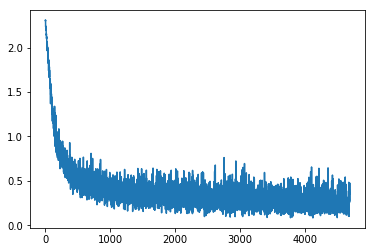

In [61]:
plt.plot(losses)